# Apache Kafka Streaming Analytics
### One Broker Setup
<br>
<hr>

#### Component: Producer
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use only one **Kafka Broker** that streams the data to the **Kafka Consumer**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [1]:
# Load dependencies and set constants
import matplotlib.pyplot as plt
import platform, socket, json, psutil, logging, multiprocessing

from confluent_kafka import Producer
from time import time, perf_counter
from statistics import mean
from datetime import datetime

DATASET_SIZE_IN_MB = 10
DATASET_SIZE_IN_MSGS = 14485

TWITTER_DATA_PATH = "/home/ubuntu/Stream-Analytics/data/dataset.json"
KAFKA_TOPIC_TWITTER = "twitter-stream"

def get_system_info():
    """ Returns system information as JSON. """
    try:
        info = {}
        info['platform'] = platform.system()
        info['platform-version'] = platform.version()
        info['hostname'] = socket.gethostname()
        info['ram'] = str(round(psutil.virtual_memory().total / (1024.0 **3))) + " GB"
        info['vCPUs'] = multiprocessing.cpu_count()
        info['architecture'] = platform.machine()

        return json.dumps(info, indent=4)
    except Exception as e:
        logging.exception(e)    

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Producer** component here, we have to make sure that the **Consumer** component is already running / expecting streaming data to ensure a performance measurement under realistic circumstances.

In [2]:
# Print system information
print(get_system_info())

# Produce the data / write it to the Kafka Cluster
producer_config = {
    "bootstrap.servers": "localhost:9092",
    'queue.buffering.max.messages': 1000000
}
p = Producer(producer_config)

{
    "platform": "Linux",
    "platform-version": "#33-Ubuntu SMP Wed Apr 29 14:32:27 UTC 2020",
    "hostname": "kafka-worker3",
    "ram": "18 GB",
    "vCPUs": 4,
    "architecture": "x86_64"
}


In [3]:
def visualize_results(throughputs_mbs_per_sec: list, throughputs_msgs_per_sec: list, mb_per_exec: int, messages_per_exec: int):
    """ Visualizes the benchmark results in plots.
    
    :param throughputs_mbs_per_sec: Throughput results, given in MBs / second
    :param throughputs_msgs_per_sec: Throughput results, given in Messages / second
    :param mb_per_exec: MBs of data processed in each benchmark execution
    :param messages_per_exec: Amount of messages processed in each benchmark execution
    """
    max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec = max(throughputs_mbs_per_sec), \
                                                        min(throughputs_mbs_per_sec), \
                                                        mean(throughputs_mbs_per_sec)
    
    max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec = max(throughputs_msgs_per_sec), \
                                                           min(throughputs_msgs_per_sec), \
                                                           mean(throughputs_msgs_per_sec)
    
    print("MB/s: | Max: {0} MB/s | Min: {1} MB/s | Avg: {2} MB/s"
          .format(max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec))
    
    print("Messages/s: | Max: {0} Messages/s | Min: {1} Messages/s | Avg: {2} Messages/s"
          .format(max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec))

    # Plot Max, Min, Avg MB/s
    fig = plt.figure(figsize=(9, 6), dpi=80)   
    plt.bar(0, max_mbs_per_sec, width=1, color='navy')
    plt.bar(1, avg_mbs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_mbs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MB/s", "Average MB/s", "Minimum MB/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in MB/s", fontsize=14, pad=12)
    plt.show() 
    
    # Plot Max, Min, Avg Messages/s
    fig = plt.figure(figsize=(9, 6), dpi=80)
    plt.bar(0, max_msgs_per_sec, width=1, color='navy')
    plt.bar(1, avg_msgs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_msgs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MSGs/s", "Average MSG/s", "Minimum MSGs/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in Messages/s", fontsize=14, pad=12)
    plt.show() 
        
    # Plot MB/s results
    executions = len(throughputs_mbs_per_sec)
    x_labels = ["Ex. {}".format(i) for i in range(1, executions+1)]
    
    fig = plt.figure(figsize=(9, 6), dpi=80)
    ax = plt.axes()
    
    ax.bar(x_labels, throughputs_mbs_per_sec, color="navy", width=0.7)
    
    ax.set_xlabel("Benchmark Executions", fontsize=12)
    ax.set_ylabel("Throughput in MB/s", fontsize=12)
    ax.set_title("Benchmark: Throughput ({} MB)".format(mb_per_exec), fontsize=15, pad=12)
    plt.show()
    
    # Plot Messages/s results
    fig = plt.figure(figsize=(9, 6), dpi=80)
    ax = plt.axes()
    
    ax.bar(x_labels, throughputs_msgs_per_sec, color="darkcyan", width=0.7)
    
    ax.set_xlabel("Benchmark Executions", fontsize=12)
    ax.set_ylabel("Throughput in Messages/s)", fontsize=12)
    ax.set_title("Benchmark: Throughput ({:,} Messages)".format(messages_per_exec), fontsize=15, pad=12)
    plt.show()

def benchmark(mb_per_exec: int = 1000, exec_count: int = 10):
    """ Executes a throughput benchmark procedure, e.g. the amount of MB per second that was 
        sent by the producer to the Broker. To get meaningful results, the benchmark procedure 
        is repeated exec_count times.
        Default is ~ 1GB per execution, while executing 10 times.
        
        :param: mb_per_exec Amount of data to send per execution, given in MB. As the dataset is 10 MB large,
                mb_per_exec % 10 = 0 should be true for the given argument.
        :param exec_count: Amount of times to repeat the benchmark procedure
    """
    print("Executing throughput benchmark ...")
    
    throughputs_in_mb = [] # MB/s
    throughputs_in_msgs = [] # Messages/s
    
    total_messages = int(DATASET_SIZE_IN_MSGS * (mb_per_exec / DATASET_SIZE_IN_MB))
    dataset_iterations = int(mb_per_exec / DATASET_SIZE_IN_MB)
    
    with open(TWITTER_DATA_PATH, "r") as dataset:
        for execution in range(exec_count):
            
            print("Starting producing: {}".format(datetime.utcnow().isoformat(sep=' ', timespec='milliseconds')))
            start = perf_counter()
            for _ in range(dataset_iterations):
                dataset.seek(0) # Jump back to first line 
                
                for tweet in dataset:
                    try:
                        p.produce(KAFKA_TOPIC_TWITTER, value=tweet)
                        p.poll(0)
                    except BufferError:
                        print('[INFO] Local producer queue is full (%d messages awaiting delivery): Trying again...\n' % len(p)) 
                        p.poll(30)

                        # Retry sending tweet
                        p.produce(KAFKA_TOPIC_TWITTER, value=tweet)   
            end = perf_counter()
            print("Stopping producing: {}".format(datetime.utcnow().isoformat(sep=' ', timespec='milliseconds')))

            
            produce_time = float(end - start)
            megabytes_per_second = mb_per_exec / produce_time
            msgs_per_second = int(total_messages / produce_time)

            print("{} Messages in {:.2f} seconds | {} Messages/s"
              .format(total_messages, produce_time, msgs_per_second))
            print("\n")

            # Save results for later visualization
            throughputs_in_mb.append(megabytes_per_second)
            throughputs_in_msgs.append(msgs_per_second)
            
    p.flush(30)
    
    print("\n" + "Benchmark procedure finished. Visualizing the results ...")
    visualize_results(throughputs_in_mb, throughputs_in_msgs, mb_per_exec, total_messages)

Executing throughput benchmark ...
Starting producing: 2021-04-30 11:44:27.450
Stopping producing: 2021-04-30 11:44:39.119
1448500 Messages in 11.67 seconds | 124131 Messages/s


Starting producing: 2021-04-30 11:44:39.120
Stopping producing: 2021-04-30 11:44:50.011
1448500 Messages in 10.89 seconds | 133006 Messages/s


Starting producing: 2021-04-30 11:44:50.013
Stopping producing: 2021-04-30 11:45:01.309
1448500 Messages in 11.30 seconds | 128235 Messages/s


Starting producing: 2021-04-30 11:45:01.309
Stopping producing: 2021-04-30 11:45:11.219
1448500 Messages in 9.91 seconds | 146167 Messages/s


Starting producing: 2021-04-30 11:45:11.219
Stopping producing: 2021-04-30 11:45:21.232
1448500 Messages in 10.01 seconds | 144707 Messages/s


Starting producing: 2021-04-30 11:45:21.235
Stopping producing: 2021-04-30 11:45:32.099
1448500 Messages in 10.86 seconds | 133334 Messages/s


Starting producing: 2021-04-30 11:45:32.100
Stopping producing: 2021-04-30 11:45:42.456
1448500 Messag

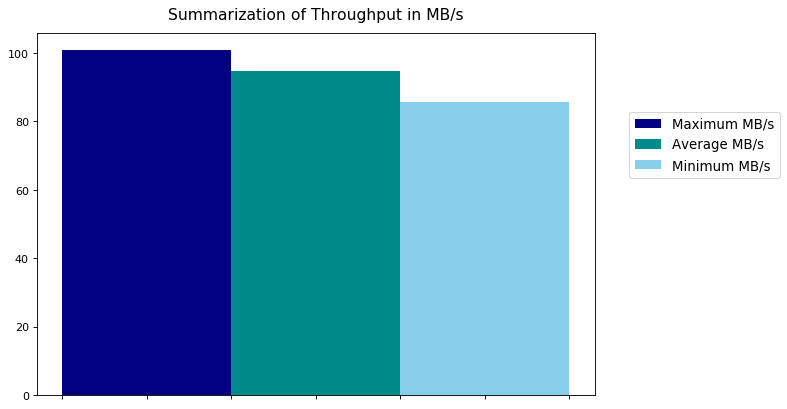

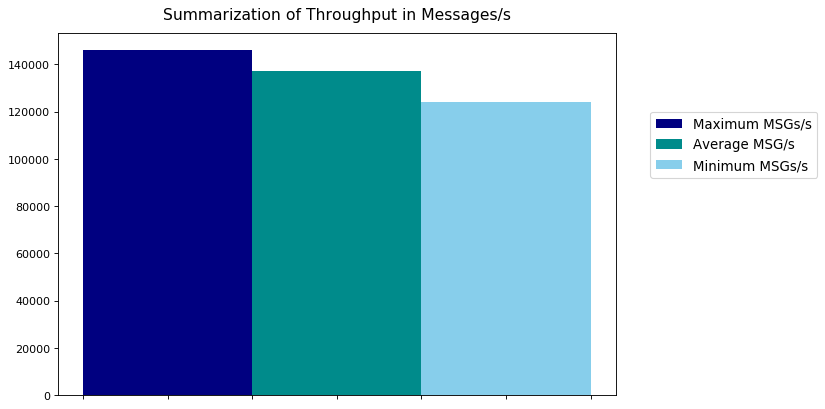

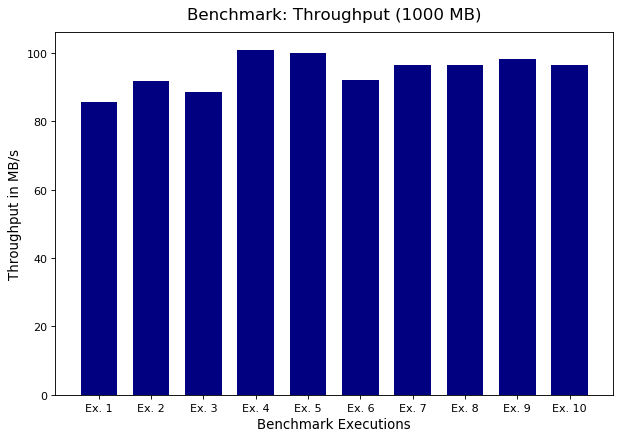

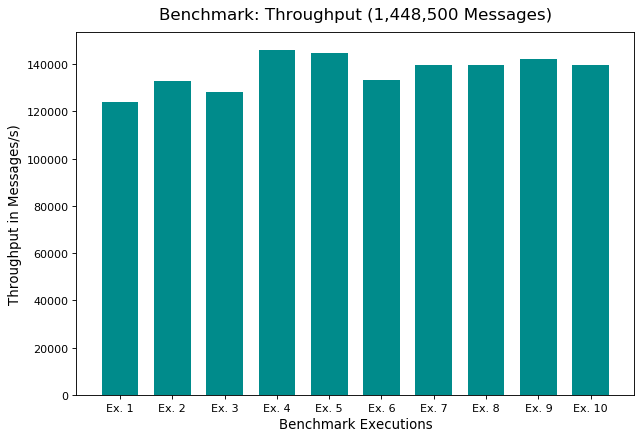

In [4]:
# Execute the benchmark
benchmark(mb_per_exec=1000, exec_count=10)